# Visualizing COVID-19 cases

In [1]:
import altair as alt
import pandas as pd
import io
import requests
from altair import datum
import numpy as np

In [2]:
from altairThemes import standardTheme as st
alt.themes.register('standardTheme', st.standardTheme)
alt.themes.enable('standardTheme')

ThemeRegistry.enable('standardTheme')

## Data Transformation

In [3]:
def case_counts(url):
    s=requests.get(url).content
    cases=pd.read_csv(io.StringIO(s.decode('utf-8')))\
        .drop(['Province/State', 'Lat', 'Long'], axis=1)\
        .groupby(['Country/Region']).sum()\
        .T.reset_index()
    
    cases['index'] = pd.to_datetime(cases['index'])
    cases = cases.melt(id_vars=['index'])
    cases.columns = ['date', 'country', 'value']
    
    return cases

In [4]:
# confirmed cases:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'

In [5]:
confirmed = case_counts(confirmed_url)
deaths = case_counts(deaths_url)

In [6]:
selCountries = [
    'Germany',
    'Italy',
    'France',
    'United Kingdom',
    'US',
    'Spain',
    'Korea, South'
]

In [7]:
confirmed_sel = confirmed.loc[(confirmed.country.isin(selCountries)&(confirmed.value>=100)),:].copy()
deaths_sel = deaths.loc[(deaths.country.isin(selCountries))&(deaths.value>0),:].copy()

## Case count per day

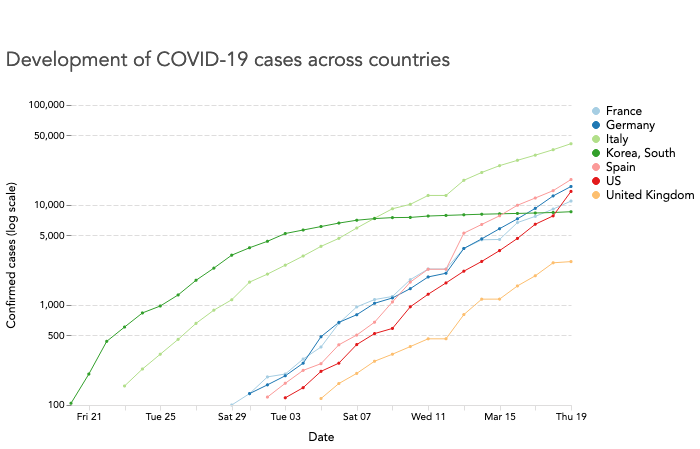

In [8]:
alt.Chart(
    confirmed_sel, 
    height=300,
    title='Development of COVID-19 cases across countries'
).mark_line(
    point=alt.OverlayMarkDef(shape='circle', size=10)
).encode(
    alt.X('date:T', title='Date'),
    alt.Y(
        'value:Q', 
        scale=alt.Scale(
            type='log', 
            bins=[100,500,1000,5000,10000,50000,100000]),
        title='Confirmed cases (log scale)'
    ),
    color='country:N')

## Case count since 100th confirmed case in country

In [9]:
confirmed_sel['days_since100'] = 0
for name, group in confirmed_sel.groupby(['country']):
    for i in range(0, len(group)):
        ix = group.index.values[i]
        confirmed_sel.loc[ix, 'days_since100']=i

In [10]:
chart_covid_cases = alt.Chart(
    confirmed_sel, 
    height=300,
    title='Development of COVID-19 cases across countries'
).mark_line(
    point=alt.OverlayMarkDef(shape='circle', size=10)
).encode(
    alt.X('days_since100:Q', title='Days since 100th case'),
    alt.Y(
        'value:Q', 
        scale=alt.Scale(
            type='log', 
            bins=[100,500,1000,5000,10000,50000,100000]),
        title='Confirmed cases (log scale)'
    ),
    color='country:N'        
)

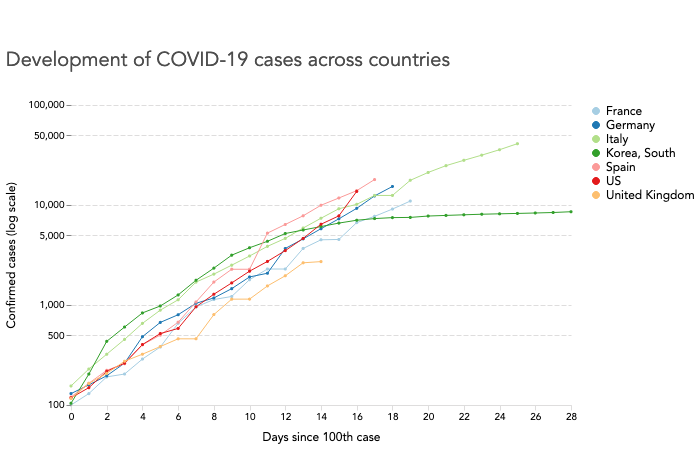

In [11]:
chart_covid_cases

In [13]:
chart_covid_cases.save('./charts/covid_cases.svg')

JavascriptException: Message: javascript error: vl is not defined
JavaScript stack:
ReferenceError: vl is not defined
    at eval (eval at executeAsyncScript (:552:26), <anonymous>:11:28)
    at eval (eval at executeAsyncScript (:552:26), <anonymous>:25:4)
    at executeAsyncScript (<anonymous>:552:47)
    at apply.$schema (<anonymous>:567:29)
    at callFunction (<anonymous>:447:22)
    at <anonymous>:461:23
    at <anonymous>:462:3
  (Session info: headless chrome=80.0.3987.149)


## Percentage growth to previous day

In [14]:
confirmed_sel['perc_growth'] = np.nan
for name, group in confirmed_sel.loc[:,['country','value']].groupby('country'):
    for i in range(1,len(group)):
        prev = group.loc[group.index.values[i-1], 'value']
        now = group.loc[group.index.values[i],'value']
        growth = now/prev
        confirmed_sel.loc[group.index.values[i],'perc_growth'] = growth
        

In [15]:
chart_growth_rates= alt.Chart(
    confirmed_sel, 
    height=300,
    title='Growth rates of COVID-19 cases across countries'
).mark_line().encode(
    alt.X('date:T', title='Days since 100th case'),
    alt.Y(
        'perc_growth:Q',
        title='Growth rate compared to previous day'
    ),
    color='country:N')

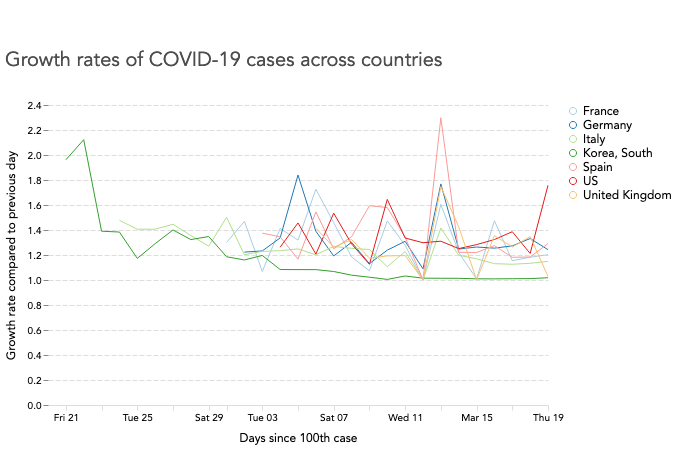

In [16]:
chart_growth_rates

In [17]:
chart_growth_rates.save('./charts/growth_rates.svg', webdriver='firefox')

TimeoutException: Message: Timeout loading page after 20000ms


## Cases per 10^6 inhabitants

In [ ]:
population = {
    'France':65129728,
    'Germany':83517045,
    'Italy':60550075,
    'Korea, South':51225308,
    'Spain':46736776,
    'US':329064917,
    'United Kingdom': 67530172,
}

In [ ]:
confirmed_sel['cases_per1m'] = np.nan
for name, group in confirmed_sel.loc[:,['country','value']].groupby('country'):
    for i in range(0,len(group)):
        cases = group.loc[group.index.values[i],'value']
        cases_per = cases/(population[name]/10**6)
        confirmed_sel.loc[group.index.values[i],'cases_per1m'] = cases_per

In [ ]:
chart_cases_per_1m = alt.Chart(
    confirmed_sel, 
    height=300,
    title='Development of confirmed COVID-19 cases per 1m inhabitants'
).mark_line().encode(
    alt.X('days_since100:Q', title='Days since 100th case'),
    alt.Y(
        'cases_per1m:Q',
        title='Cases per 1m inhabitants'
    ),
    color='country:N')

In [ ]:
chart_cases_per_1m

In [ ]:
chart_cases_per_1m.save('./charts/cases_per_1m.svg', webdriver='firefox')

## Cases per Intensive Care Units (ICU)

Definitions of ICUs vary a lot between countries. Numbers have to be viewed with care...
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3568952/#B12
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3551445/

In [ ]:
icu_per_100000 = {
    'France':np.nan,
    'Germany':25,
    'Italy':np.nan,
    'Korea, South':np.nan,
    'Spain':10,
    'US':np.nan,
    'United Kingdom': 3,
}

In [ ]:
confirmed_sel['cases_perICU'] = np.nan
for name, group in confirmed_sel.loc[:,['country','value']].groupby('country'):
    for i in range(0,len(group)):
        cases = group.loc[group.index.values[i],'value']
        cases_per = cases/(icu_per_100000[name]*population[name]/10**5)
        confirmed_sel.loc[group.index.values[i],'cases_perICU'] = cases_per

In [ ]:
chart_cases_per_icu = alt.Chart(
    confirmed_sel, 
    height=300,
    title='Development of confirmed COVID-19 cases per ICU'
).mark_line().encode(
    alt.X('days_since100:Q', title='Days since 100th case'),
    alt.Y(
        'cases_perICU:Q',
        title='Cases per ICU'
    ),
    color='country:N')

In [ ]:
chart_cases_per_icu

In [ ]:
chart_cases_per_icu.save('./charts/cases_per_icu.svg', webdriver='firefox')

## Deaths

In [ ]:
chart_deaths = alt.Chart(
    deaths_sel, 
    height=300,
    title='Development of confirmed COVID-19 deaths'
).mark_line(
    point=alt.OverlayMarkDef(shape='circle', size=10)
).encode(
    alt.X('days_since100:Q', title='Days since 100th case'),
    alt.Y(
        'value:Q',
        title='COVID-19 deaths'
    ),
    color='country:N')

In [ ]:
chart_deaths

In [ ]:
chart_deaths.save('./charts/deaths.svg', webdriver='firefox')

## Deaths compared to infections

In [ ]:
both = confirmed.join(deaths, rsuffix='_d').drop(['date_d', 'country_d'], axis=1)

In [ ]:
both.columns =['date', 'country', 'confirmed', 'deaths']

In [ ]:
both['death_rate']=both.deaths/both.confirmed

In [ ]:
both_sel = both.loc[(both.country.isin(selCountries))&(both.confirmed>100),:].copy()

In [ ]:
chart_deaths_infections = alt.Chart(
    both_sel, 
    height=300,
    title='Development of confirmed COVID-19 deaths in infected persons'
).mark_line(
    point=alt.OverlayMarkDef(shape='circle', size=10)
).encode(
    alt.X('date:T', title='Date'),
    alt.Y(
        'death_rate:Q',
        title='share of COVID-19 deaths in infected persons'
    ),
    color='country:N')

In [ ]:
chart_deaths_infections

In [ ]:
chart_deaths_infections.save('./charts/deaths_infections.svg', webdriver='firefox')

In [ ]:
both_sel['days_since100'] = 0
for name, group in both_sel.groupby(['country']):
    for i in range(0, len(group)):
        ix = group.index.values[i]
        both_sel.loc[ix, 'days_since100']=i

In [ ]:
chart_deaths_infections_100 = alt.Chart(
    both_sel, 
    height=300,
    title='Development of confirmed COVID-19 deaths in infected persons'
).mark_line(
    point=alt.OverlayMarkDef(shape='circle', size=10)
).encode(
    alt.X('days_since100:Q', title='Days since 100th case'),
    alt.Y(
        'death_rate:Q',
        title='share of COVID-19 deaths in infected persons'
    ),
    color='country:N')

In [ ]:
chart_deaths_infections_100

In [ ]:
chart_deaths_infections_100.save('./charts/deaths_infections_100.svg', webdriver='firefox')

In [ ]:
both_sel.columns

## Exporting the data

In [ ]:
deaths_sel.to_csv('./data/deaths_sel.csv', sep=',', index=False)

In [ ]:
both_sel.to_csv('./data/all_sel.csv', sep=',', index=False)

In [ ]:
confirmed_sel.to_csv('./data/confirmed_sel.csv', sep=',', index=False)